# Spatial cell-cell interaction tutorial


## 1. Load data

In [1]:
import stlearn as st
import scanpy as sc
import pandas as pd
import numpy as np
# read in visium dataset downloaded from: support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Breast_Cancer_Block_A_Section_1
visium = sc.read_csv("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\GSE144239_ST_Visium_counts.txt.gz", delimiter="\t")
visium.var.index = [item.split('_')[1] for item in list(visium.var.index)]

In [2]:
# get patient 4 replicate 1
data = visium[2:,(visium[0].X==4) & (visium[1,].X==1)].copy().T
#positions_visium = sc.read_csv("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\GSM4565823_P4_rep1_tissue_positions_list.csv.gz")
#positions = positions_visium[list(data.obs.index),]
st.add.image(data, "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\GSM4565823_P4_rep1_tissue_hires_image.png", "P4_1")
st.add.positions(data, position_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\GSM4565823_P4_rep1_tissue_positions_list.csv.gz",
                scale_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\GSM4565823_P4_rep1_scalefactors_json.json",
                quality="high")
data.uns['spatial']['P4_1']['scalefactors']={"spot_diameter_fullres": 378.00252339152325, 
                                                 "tissue_hires_scalef": 0.03792476, 
                                                 "fiducial_diameter_fullres": 610.61946086323, 
                                                 "tissue_lowres_scalef": 0.011377427}

Added tissue image to the object!


## 2 Preprocessing


### 2.1. filter, normalize, scale & PCA

In [3]:
st.pp.filter_genes(data,min_cells=3)
st.pp.normalize_total(data)
st.pp.scale(data)
data.obsm['scaled'] = pd.DataFrame(data.X, data.obs_names, data.var_names)

Normalization step is finished in adata.X
Scale step is finished in adata.X


## 3. Cell-cell interaction analysis

### 3.1 Cell type heterogeneity

label transfer results added to adata.uns['label_transfer']
predicted label added to adata.obs['predictions'].


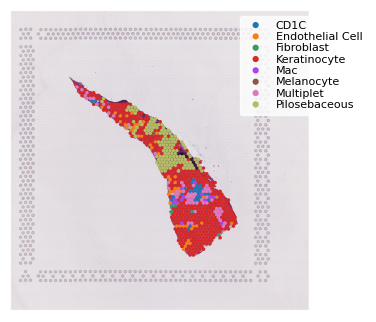

In [4]:
# Read in the spot/cell type predictions based on label transfer
st.add.labels(data, 'C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Skin\\predictions.csv')
st.pl.cluster_plot(data, use_label="predictions", dpi=100, name='label_transfer', output='.')

#### Count the density of cell types

Counts for cluster (cell type) diversity stored into adata.uns['cci_het']


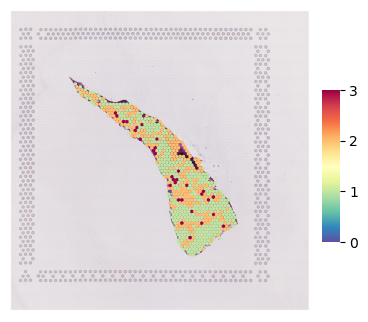

In [5]:
st.tl.cci.het.count(data, use_clustering='label_transfer', distance=0)
st.pl.het_plot(data, use_het='cci_het', dpi=100, name='het_predictions', output='.')

### 3.2 Clustering based on Ligand-Receptor (L-R) co-expression

#### cluster spatial spots based on the proportion of known ligand-receptor co-expression among the neighbouring spots

Altogether 2 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata\.uns['cci_lr']


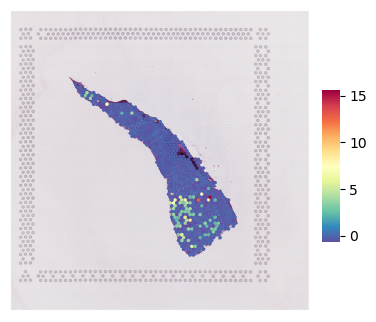

In [6]:
data.uns["lr"] = ['MMP9_LRP1']
#st.add.lr(adata=data, db_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\cellphonedb\\connectomedb2020.txt", sep="\t", source="connectomedb")
st.tl.cci.base.lr(adata=data, use_data='scaled', distance=0)
st.pl.het_plot(data, use_het='cci_lr', dpi=100, name='cci_lr', output='.')

#### Merge results from cci clustering and cell type heterogeneity

Results of spatial interaction analysis has been written to adata.uns['merged']


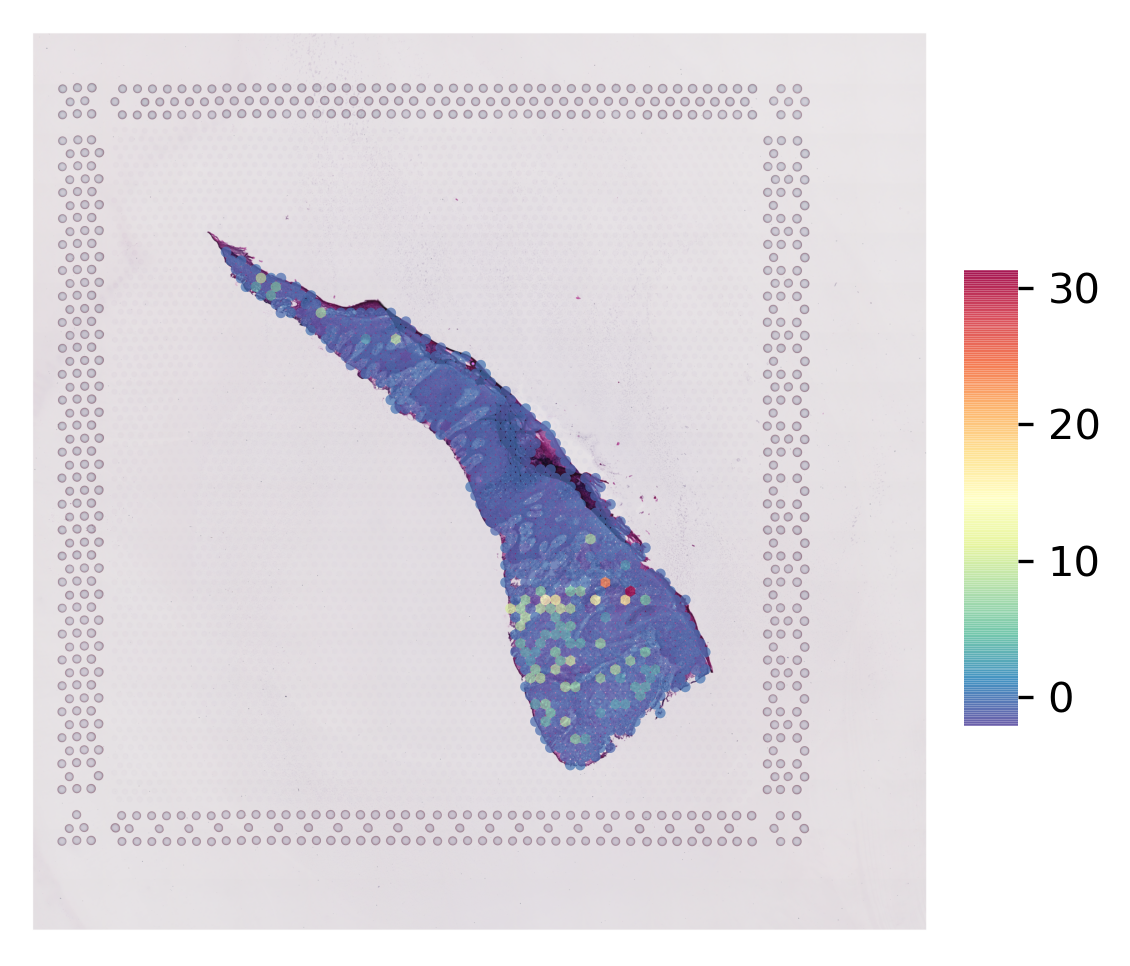

In [7]:
# merge the number of spots belonging to largest lr cci cluster, with the number of different cell types within each window
st.tl.cci.merge(data, use_lr='cci_lr', use_het='cci_het')
st.pl.het_plot(data, use_het='merged', dpi=300, data_alpha=0.7, name='merged', output='.')

In [8]:
st.tl.cci.permutation(data, n_pairs=200, use_data='scaled')

AnnData object with n_obs × n_vars = 722 × 15692
    obs: 'imagerow', 'imagecol', 'predictions'
    var: 'n_cells', 'mean', 'std'
    uns: 'spatial', 'label_transfer', 'tmp_color', 'cci_het', 'lr', 'cci_lr', 'merged', 'background', 'merged_pvalues', 'merged_sign'
    obsm: 'filtered_counts', 'normalized_total', 'scaled'

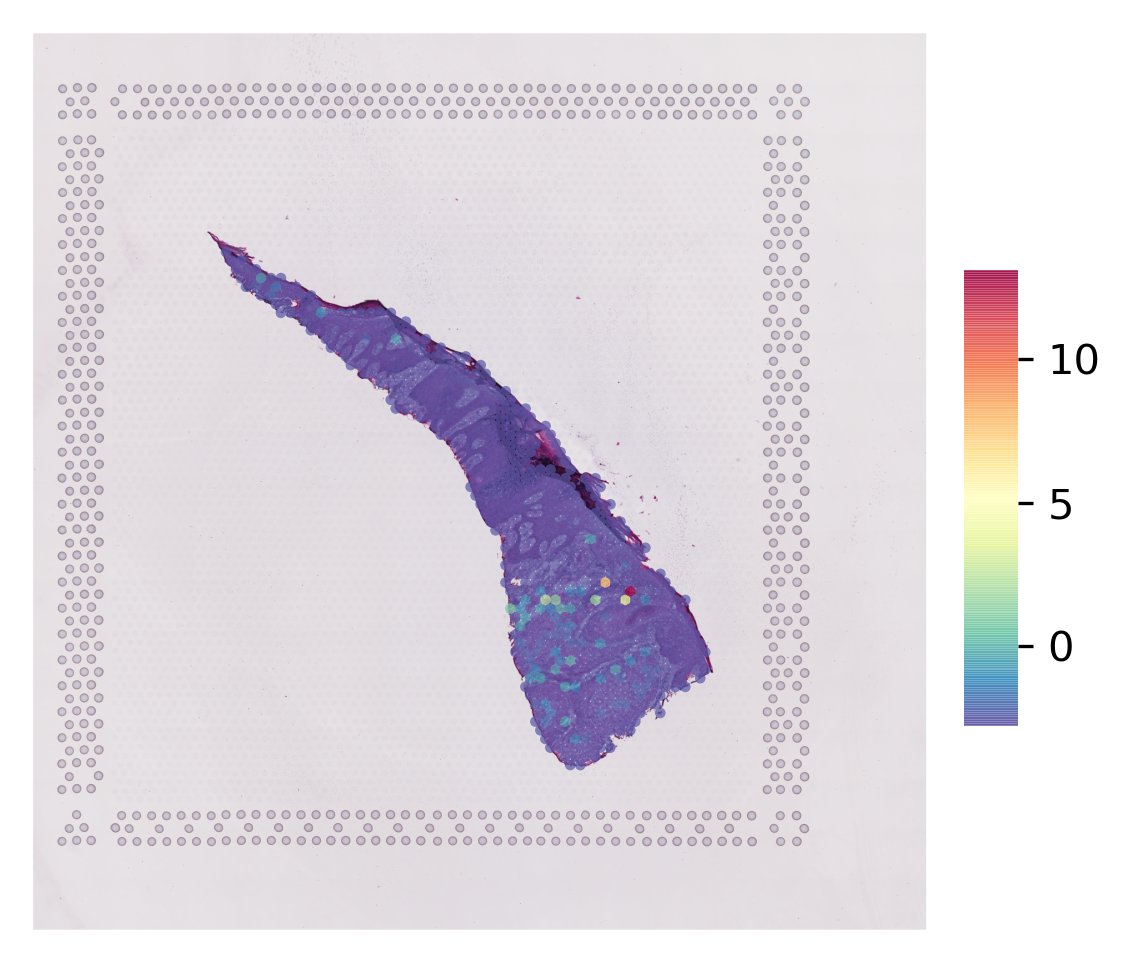

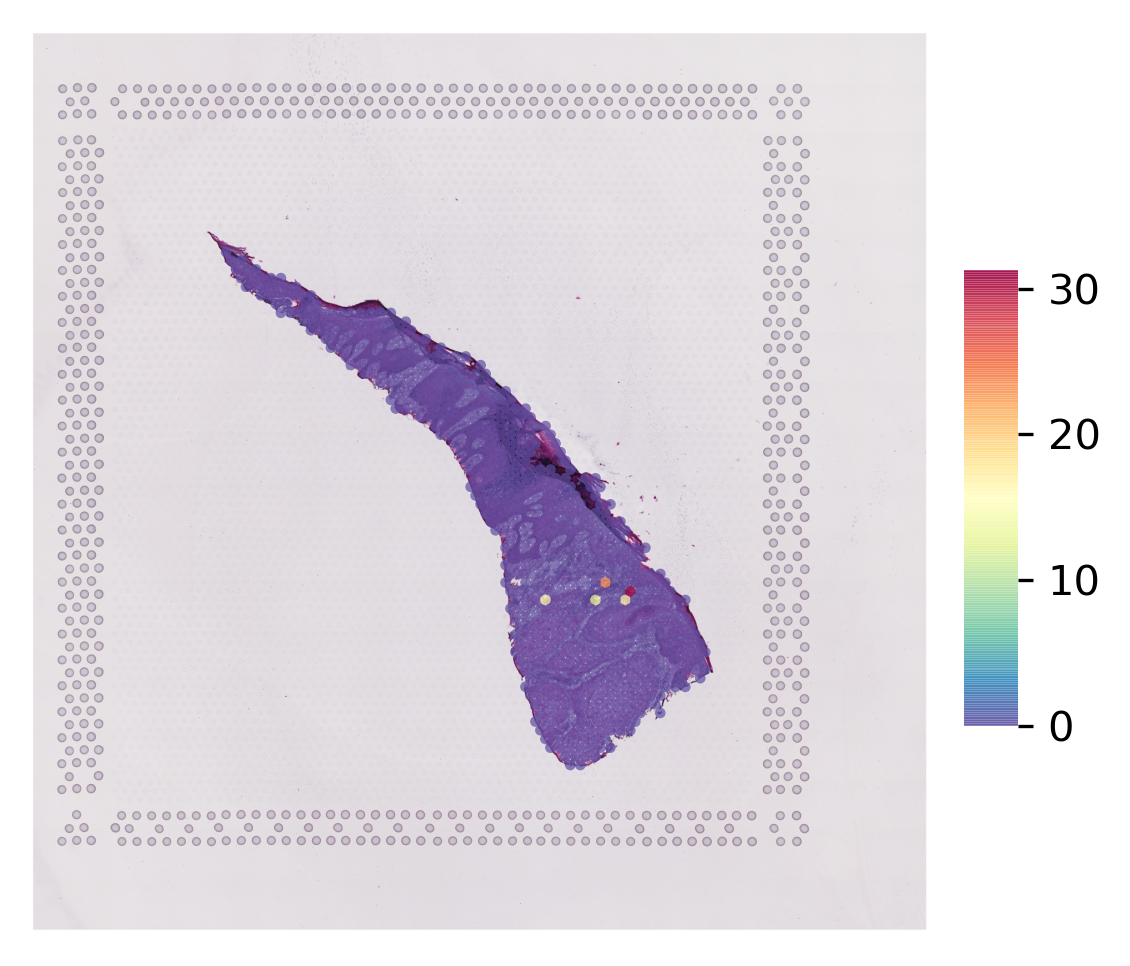

In [9]:
st.pl.het_plot(data, use_het='merged_pvalues', dpi=300, data_alpha=0.7, name='permutation', output='.')
st.pl.het_plot(data, use_het='merged_sign', dpi=300, data_alpha=0.7, name='final', output='.')